## 모델 학습

### 각 이미지 ROI에 대한 밝기/깊이 기반의 통계적 파생 피처 계산 및 머신러닝 입력용 매트릭스 만들기

In [ ]:
# 1. csv 파일 병합
# 2. 폴더명 보정
# 3. 파일명에 _depth 접미사 추가
# 4. ROI(관심영역) 이미지 불러오기 및 파생 피처 계산
# 5. 최종 DataFrame 및 피처 매트릭스 생성

import pandas as pd
import numpy as np
import cv2
import os

# 1) CSV 합치기
csv_info = {
    "clean":        ("clean_120_ver1/clahe_clean_120_ver1.csv",        "clean_120_ver1"),
    "medium_clean": ("medium_clean_117_ver1/medium_clean_117_ver1.csv",    "medium_clean_117"),
    "medium_heavy": ("medium_heavy_110_ver1/medium_heavy_110_ver1.csv",    "medium_heavy_110"),
    "heavy":        ("heavy_122_ver1/clahe_heavy_122_ver1.csv",                  "heavy_122_ver1"),
}
df_list = []
for cls, (csv_path, folder) in csv_info.items():
    tmp = pd.read_csv(csv_path)
    tmp["class"]      = cls
    tmp["img_folder"] = folder
    df_list.append(tmp)
df_all = pd.concat(df_list, ignore_index=True)

# 2) img_folder 값 교정
df_all.loc[df_all['img_folder']=="medium_clean_117", "img_folder"] = "medium_clean_117_ver1"
df_all.loc[df_all['img_folder']=="medium_heavy_110", "img_folder"] = "medium_heavy_110_ver1"
# (실제 폴더명으로 정확히 매칭)

# 3) filename에 _depth 붙이기
def fix_fn(fn):
    base, ext = os.path.splitext(fn)
    return fn if base.endswith("_depth") else f"{base}_depth{ext}"

df_all['filename'] = df_all['filename'].apply(fix_fn)

# 확인
print("▶ img_folder unique:", df_all['img_folder'].unique())
print("▶ sample file exists:",
      os.path.exists(os.path.join(df_all.loc[0,'img_folder'], df_all.loc[0,'filename'])))

# --- 이제 파생 피처 계산(위에서 짠 코드) ---

# 4) 파생 피처용 리스트 초기화
trimmed_means, depth_bright_ratios = [], []
brightness_stds, depth_stds = [], []
hist_feats, valid_idx, missing = [], [], []

for idx, row in df_all.iterrows():
    img_path = os.path.join(row.img_folder, row.filename)
    img = cv2.imread(img_path)
    if img is None:
        missing.append(img_path)
        continue

    x,y,w,h = map(int, row[['x','y','w','h']])
    roi = cv2.cvtColor(img[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)

    # 통계
    bm, bs = roi.mean(), roi.std()
    dm, ds = row.depth_mean, row.depth_std
    flat = np.sort(roi.flatten())
    lo, hi = int(len(flat)*0.05), int(len(flat)*0.95)
    tm = flat[lo:hi].mean()
    ratio = dm/(bm+1e-6)
    hist, _ = np.histogram(roi.flatten(), bins=10, range=(0,255))

    trimmed_means.append(tm)
    depth_bright_ratios.append(ratio)
    brightness_stds.append(bs)
    depth_stds.append(ds)
    hist_feats.append(hist/hist.sum())

    valid_idx.append(idx)

# 5) df_all 재정의 및 X 생성
df_all = df_all.loc[valid_idx].reset_index(drop=True)
df_all['brightness_std']      = brightness_stds
df_all['depth_std']           = depth_stds
df_all['bright_trimmed_mean'] = trimmed_means
df_all['depth_bright_ratio']  = depth_bright_ratios

hist_feats = np.vstack(hist_feats)
for i in range(10):
    df_all[f'bright_hist_{i}'] = hist_feats[:,i]

feature_cols = [
    'brightness_mean','brightness_std','depth_mean','depth_std',
    'bright_trimmed_mean','depth_bright_ratio'
] + [f'bright_hist_{i}' for i in range(10)]
X = df_all[feature_cols]
print("✅ 최종 피처 행/열:", X.shape)


▶ img_folder unique: ['clean_120_ver1' 'medium_clean_117_ver1' 'medium_heavy_110_ver1'
 'heavy_122_ver1']
▶ sample file exists: True
✅ 최종 피처 행/열: (468, 16)


### 불균형 데이터 처리 -> 하이퍼파라미터 튜닝,평가 및 학습된 파이프라인 요소를 재사용 가능한 형태(.pkl)로 내보내는 전체 워크플로우

In [ ]:
# 1. 데이터 로드 및 라벨링
# 2. 훈련/테스트 데이터 분할(8:2)
# 3. 오버샘플링 설정 (중간 클래스(1, 'Mid')만 200개 샘플이 되도록)
# 4. Imbalanced-Learn 파이프라인 구성
# 5. 하이퍼파라미터 탐색
# 6. 모델 평가 (최적 파라미터 출력, 테스트 세트에 대한 분류 리포트와 혼동 행렬 출력)
# 7. 최종 모델/스케일러 저장(그리드의 best_estimator_ 에서 스케일러(scaler.pkl)와 분류기(rf_classifier.pkl)를 분리해 joblib.dump로 파일 저장

import pandas as pd
import numpy as np
import os
import cv2
import joblib

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# 1) 데이터 & 피처 준비
df_all = pd.read_csv("all_with_score_and_class.csv")  # 파생 피처 포함된 CSV
feature_cols = [
    'brightness_mean','brightness_std','depth_mean','depth_std',
    'bright_trimmed_mean','depth_bright_ratio'
] + [f'bright_hist_{i}' for i in range(10)]
X = df_all[feature_cols]
y = df_all['label4'].map(lambda l: 0 if l <= 33 else (1 if l <= 66 else 2))

# 2) Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Mid(1)만 오버샘플링
ros = RandomOverSampler(sampling_strategy={1:200}, random_state=42)

# 4) imblearn Pipeline 구성
pipe = ImbPipeline([
    ('oversample', ros),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# 5) GridSearchCV로 하이퍼파라미터 탐색
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth':    [None, 10],
}
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=1,    # 병렬 off
    verbose=1
)
grid.fit(X_train, y_train)

# 6) 평가
print("Best params:", grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(
    y_test, y_pred,
    labels=[0,1,2],
    target_names=['Low','Mid','High'],
    zero_division=0
))
print("Confusion Matrix:\n",
      confusion_matrix(y_test, y_pred, labels=[0,1,2]))

# 7) 학습된 스케일러·분류기 분리 저장
best_pipe = grid.best_estimator_
scaler     = best_pipe.named_steps['scaler']
clf        = best_pipe.named_steps['clf']

joblib.dump(scaler, "scaler.pkl")
joblib.dump(clf,    "rf_classifier.pkl")
print("✅ Scaler(saved as scaler.pkl) and Classifier(saved as rf_classifier.pkl) saved.")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__max_depth': None, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         0
         Mid       0.77      0.71      0.74        14
        High       0.84      0.88      0.86        24

    accuracy                           0.82        38
   macro avg       0.54      0.53      0.53        38
weighted avg       0.81      0.82      0.81        38

Confusion Matrix:
 [[ 0  0  0]
 [ 0 10  4]
 [ 0  3 21]]
✅ Scaler(saved as scaler.pkl) and Classifier(saved as rf_classifier.pkl) saved.


### 잔차 기반 보정 모델 학습

In [ ]:
# 잔차 기반 보정 모델 학습

# 1. 회귀모델 로드
# 2. 데이터 준비 (파생 피처를 포함한 전체데이터 읽어와서 리스트에 명시된 밝기/깊이 통계피처로 설명 변수와 원본연속 레이블을 준비)
# 3. 초기 예측 및 클래스화 (회귀모델로 연속 값 pred4예측, 예측값을 <=33 -> 클래스 0(“Low”), 34~66 → 1(“Mid”), >66 → 2(“High”)로 매핑해 init_cls 생성)
# 4. Mid 클래스 오분류 샘플 식별 (실제 y4==33인(정상 Mid) 샘플 중에서, 초기 분류(init_cls)가 2(“High”)인 경우만 need_corr=1로 표시)
# 5. 보정 모델 학습 조건 확인 (Mid 샘플 개수가 2개 미만이면 학습을 건너뜀)
# 6. 보정용 데이터 분할 & 모델 학습 (Mid 샘플만 골라 설명 변수 Xc, 타깃(need_corr)으로 설정 -> 80/20 stratified split 후 StandardScaler → LogisticRegression 파이프라인(corr_pipe)을 학습)
# 7. 평가 및 저장 (테스트 파트에서 classification_report 출력/ 학습된 보정 분류기(corr_pipe)를 correction_clf.pkl로 저장)
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 회귀 모델 로드 (예: best_lgb_pipeline.pkl)
reg = joblib.load("best_lgb_pipeline.pkl")

# 전체 피처 & 레이블
df_all = pd.read_csv("all_with_score_and_class.csv")
feature_cols = [
    'brightness_mean','brightness_std','depth_mean','depth_std',
    'bright_trimmed_mean','depth_bright_ratio'
] + [f'bright_hist_{i}' for i in range(10)]
X_all = df_all[feature_cols]
y4    = df_all['label4']
pred4 = reg.predict(X_all)

# 3) 초기 클래스화 및 Mid 오분류 표시
init_cls = np.where(pred4 <= 33, 0, np.where(pred4 <= 66, 1, 2))
mask_mid = (y4 == 33)
need_corr = np.zeros(len(init_cls), dtype=int)
need_corr[mask_mid & (init_cls == 2)] = 1

# 4) Mid 샘플 개수 확인
mid_count = mask_mid.sum()
if mid_count < 2:
    print(f"⚠️ Mid 샘플이 {mid_count}개로 부족하여 보정 모델 학습을 건너뜁니다.")
else:
    # 보정 데이터 분할
    Xc = X_all[mask_mid]
    yc = need_corr[mask_mid]
    Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
        Xc, yc, test_size=0.2, random_state=42,
        stratify=yc if yc.sum() > 1 else None
    )

    # 보정 분류기 학습
    corr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
    ])
    corr_pipe.fit(Xc_tr, yc_tr)

    # 평가
    print(classification_report(yc_te, corr_pipe.predict(Xc_te), zero_division=0))

    # 저장
    joblib.dump(corr_pipe, "correction_clf.pkl")
    print("✅ correction_clf.pkl 생성 완료!")


⚠️ Mid 샘플이 0개로 부족하여 보정 모델 학습을 건너뜁니다.


c:\Users\USER\Desktop\code_project1\project\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### 4개의 주요 피처만을 사용해 오염도 점수(또는 레이블)를 예측한느 랜덤포레스트 회귀모델 학습 및 저장

In [ ]:
# 1. 데이터 로드
# 2. 입력 피처(X) / 타깃(y) 분리
# 3. 학습/테스트 데이터 분할
# 4. 파이프라인 구성
# 5. 모델 학습
# 6. 모델 저장

import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 데이터 로드
df = pd.read_csv("all_with_score_and_class.csv")

# 4개 피처 & 레이블
X4 = df[['brightness_mean','brightness_std','depth_mean','depth_std']]
y4 = df['label4']

# 학습/테스트 분할
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, test_size=0.2, random_state=42
)

# 파이프라인 정의
pipe4 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
])

# 학습
pipe4.fit(X4_train, y4_train)

# 저장
joblib.dump(pipe4, "rf_4feat_pipeline.pkl")
print("✅ 4-피처 전용 모델 저장 완료: rf_4feat_pipeline.pkl")


✅ 4-피처 전용 모델 저장 완료: rf_4feat_pipeline.pkl


# test 파일 전처리 (csv변환)

In [ ]:
# 1. 설정
# 2. 이미지 전처리 및 변환
# 3. custom vision으로 객체 감지
# 4. 결과 저장

# 하나의 폴더만 clahe 전처리 처리
import os
import cv2
import numpy as np
import pandas as pd
import requests
import torch
from tqdm import tqdm
from PIL import Image

# === MiDaS 모델 불러오기 ===
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large", trust_repo=True)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
transform = midas_transforms.dpt_transform

# === Custom Vision 설정 ===
PREDICTION_KEY = "5sloqMYWiZSpfCd7HZgQ9ZpfuQAXnRWwjSw648WjXGr5Fy5f7imcJQQJ99BFACYeBjFXJ3w3AAAIACOGBDCR"
PREDICTION_URL = "https://7aiteam05ai012-prediction.cognitiveservices.azure.com/customvision/v3.0/Prediction/f360eeb2-f8df-441e-8bed-f27d3ef1797a/detect/iterations/Iteration2/image"

# === 보조 함수 ===
def get_customvision_bboxes(image_path):
    with open(image_path, "rb") as image_file:
        headers = {
            "Prediction-Key": PREDICTION_KEY,
            "Content-Type": "application/octet-stream"
        }
        response = requests.post(PREDICTION_URL, headers=headers, data=image_file)
        response.raise_for_status()
        predictions = response.json()["predictions"]
        if not predictions:
            return []

        # 가장 높은 확률 하나만 추출
        best = max(predictions, key=lambda x: x["probability"])
        if best["probability"] > 0.5:
            return [best["boundingBox"]]
        else:
            return []
        # return [p["boundingBox"] for p in predictions if p["probability"] > 0.5]

def clahe_normalize(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

def get_bbox_roi(image, bbox, img_w, img_h):
    x = int(bbox["left"] * img_w)
    y = int(bbox["top"] * img_h)
    w = int(bbox["width"] * img_w)
    h = int(bbox["height"] * img_h)
    roi = image[y:y + h, x:x + w]
    return roi, (x, y, w, h)

# === 입력 & 출력 폴더 설정 ===
input_folder = "test4"           # 예측 대상 이미지 폴더           # "사용자 입력!!!!!"
output_folder = "test4_ver1"         # "사용자 입력!!!!!"
os.makedirs(output_folder, exist_ok=True)

summary = []

# === 전체 이미지 순회 처리 ===
for filename in tqdm(os.listdir(input_folder)):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    path = os.path.join(input_folder, filename)
    bgr = cv2.imread(path)
    if bgr is None:
        continue

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    clahe_img = clahe_normalize(rgb)
    gray = cv2.cvtColor(clahe_img, cv2.COLOR_RGB2GRAY)

    # === MiDaS depth 예측 ===
    input_tensor = transform(clahe_img)
    with torch.no_grad():
        pred = midas(input_tensor)
        pred = torch.nn.functional.interpolate(
            pred.unsqueeze(1), size=rgb.shape[:2], mode="bicubic", align_corners=False
        ).squeeze()
    depth_map = pred.cpu().numpy()

    # === 시각화용 컬러맵 ===
    mean_depth = np.mean(depth_map)
    vmin, vmax = max(0, mean_depth - 5), mean_depth + 5
    clipped = np.clip(depth_map, vmin, vmax)
    norm = ((clipped - vmin) / (vmax - vmin) * 255).astype(np.uint8)
    depth_colored = cv2.applyColorMap(norm, cv2.COLORMAP_INFERNO)

    # === 커스텀비전으로 bbox 예측 ===
    bboxes = get_customvision_bboxes(path)

    for i, bbox in enumerate(bboxes):
        roi_gray, (x, y, w, h) = get_bbox_roi(gray, bbox, rgb.shape[1], rgb.shape[0])
        roi_depth, _ = get_bbox_roi(depth_map, bbox, rgb.shape[1], rgb.shape[0])

        # 중심 축소 (표준편차 기반)
        if np.std(roi_depth) > 5.0:
            x, y = x + w // 4, y + h // 4
            w, h = w // 2, h // 2
            roi_gray = gray[y:y + h, x:x + w]
            roi_depth = depth_map[y:y + h, x:x + w]

        # 통계 수집
        brightness_mean = roi_gray.mean()
        brightness_std = roi_gray.std()
        depth_mean = roi_depth.mean()
        depth_std = roi_depth.std()

        # 박스 시각화
        cv2.rectangle(depth_colored, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(depth_colored, f"{depth_mean:.2f}", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

        summary.append({
            "filename": filename,
            "bbox_index": i,
            "brightness_mean": brightness_mean,
            "brightness_std": brightness_std,
            "depth_mean": depth_mean,
            "depth_std": depth_std,
            "x": x, "y": y, "w": w, "h": h
        })

    # 시각화 이미지 저장
    save_path = os.path.join(output_folder, filename.rsplit('.', 1)[0] + "_depth.jpg")
    cv2.imwrite(save_path, depth_colored)

# === CSV 저장 ===
df = pd.DataFrame(summary)
csv_path = os.path.join(output_folder, "clahe_test_midas_test4.csv")
df.to_csv(csv_path, index=False)
print(f"✅ 분석 완료: {csv_path}")

Using cache found in C:\Users\USER/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\USER/.cache\torch\hub\intel-isl_MiDaS_master
100%|██████████| 43/43 [03:02<00:00,  4.23s/it]

✅ 분석 완료: test4_ver1\clahe_test_midas_test4.csv


# test 파일 4개 피처 전처리

In [120]:
import pandas as pd
import numpy as np
import joblib

# 모델 로드
pipe4 = joblib.load("rf_4feat_pipeline.pkl")

# 테스트 CSV
df_test = pd.read_csv("test4_ver1/clahe_test_midas_test4.csv")

# 4개 피처 입력
X4_new = df_test[['brightness_mean','brightness_std','depth_mean','depth_std']]

# 예측
scores = pipe4.predict(X4_new)
df_test['pred_score']  = scores
df_test['pred_class3'] = np.where(scores<=33, 'Low',
                           np.where(scores<=66, 'Mid', 'High'))

# 결과 저장
df_test.to_csv("test4_ver1/4feat_inference.csv", index=False)
print("✅ 4-피처 추론 완료 → 4feat_inference.csv")


✅ 4-피처 추론 완료 → 4feat_inference.csv


# TEST 결과

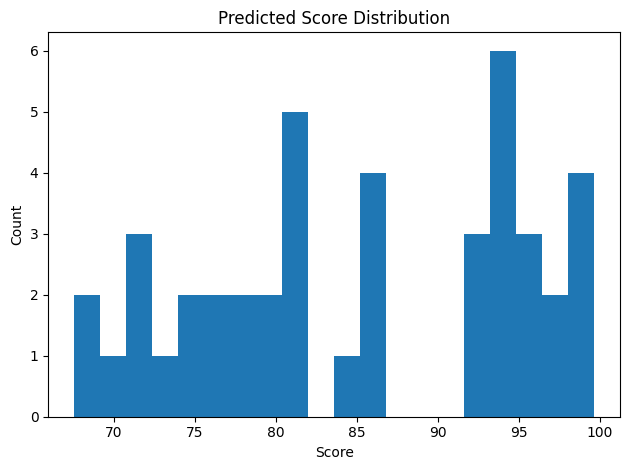

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 1) 예측 결과 로드
df = pd.read_csv("test4_ver1/4feat_inference.csv")

# 2) 3-클래스 분류 (Low/Mid/High)
df['pred_class3'] = pd.Categorical(df['pred_class3'], categories=['Low','Mid','High'])

# 3) (옵션) 실제 레이블이 있다면 평가
if 'label3' in df.columns:
    print(classification_report(df['label3'], df['pred_class3'], zero_division=0))

# 4) 예측 점수 분포 살펴보기
plt.figure()
plt.hist(df['pred_score'], bins=20)
plt.title("Predicted Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5) 혼동행렬 시각화
cm = confusion_matrix(df['pred_score'], df['pred_class3'], labels=['Low','Mid','High'])
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1,2], ['Low','Mid','High'])
plt.yticks([0,1,2], ['Low','Mid','High'])
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white')
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# ---------------------------------------------------------------

# ---------------------------------------------------------------

#----------------------